In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import random
import torch
import pickle
import math

In [2]:
print(f'PyTorch version: {torch.__version__}, CUDA version: {torch.version.cuda}')

PyTorch version: 2.1.0+cu121, CUDA version: 12.1


In [3]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
# disable interactive plots
%matplotlib inline

# enable interactive plots
# %matplotlib notebook

In [5]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss


In [6]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True, normalize_factor=1):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)
        
        self.normalize_factor = normalize_factor

    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)

        # Encode the graph features into the hidden space
        # x = self.node_encoder(data.x)
        if self.normalize_factor!=1:
            temp = data.x.clone().detach()
            temp[:,1] *= self.normalize_factor
            x = self.node_encoder(temp)
        else:
            x = self.node_encoder(data.x.clone().detach())

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)


In [7]:
def is_x(hit):
    for Z in xs:
        #print(hit,hit[0],Z, xs)
        if math.isclose(hit[0], Z, abs_tol=2): #1):
            return True
    return False

def is_y(hit):
    for Z in ys:
        #print(hit,hit[0],Z, xs)
        if math.isclose(hit[0], Z, abs_tol=2): #1):
            return True
    return False

def check_ch2(event):
    zx_mu, zx_e, x_mu, x_e, zy_mu, zy_e, y_mu, y_e = [], [], [], [], [], [], [], []
    for hit in event:
        if is_x(hit) and hit[0] < 300:
            if hit[2] in [0,1]:
                zx_mu.append(hit[0])
                x_mu.append(hit[1])
            else:
                zx_e.append(hit[0])
                x_e.append(hit[1])
        if is_y(hit) and hit[0] < 300:
            if hit[2] in [0,1]:
                zy_mu.append(hit[0])
                y_mu.append(hit[1])
            else:
                zy_e.append(hit[0])
                y_e.append(hit[1])
                
    #ax.scatter(z_mu, x_mu, c='b')
    px = np.polyfit(zx_mu, x_mu, 1)
    chi_squared_x = np.sum((np.polyval(px, zx_mu) - x_mu) ** 2)
    
    py = np.polyfit(zy_mu, y_mu, 1)
    chi_squared_y = np.sum((np.polyval(py, zy_mu) - y_mu) ** 2)
    
    return max(chi_squared_x, chi_squared_y)

In [8]:
z_scale = 100.0
events_file_name = '/storage/MUonE/ehess/FilesEvents/events2D_NormalSample_5abc6c_1.pickle'

z_s = [ 118. , 122. , 155.4, 156.7, 189.5, 194. , 218. , 222. , 255.4, 256.7, 289.5, 294. ]
#z_s = [ 18, 21, 55.4, 56.7, 89.5, 93,  118. , 122. , 155.4, 156.7, 189.5, 194. , 218. , 222. , 255.4, 256.7, 289.5, 294. ]
xs = [18., 89.5, 118., 189.5, 218., 289.5] # z-coordinates of layers measuring x
ys = [21., 93, 122., 194., 222., 294.] # z-coordinates of layers measuring y
#stereos = [55.4, 56.7, 155.4, 156.7, 255.4, 256.7]

# def z_to_layer(z):
#     for layer, Z in enumerate(z_s):
#         if math.isclose(z, Z, abs_tol = 1.2):
#             return layer
#     return None

def new_z_to_layer(z):
    differences = [abs(z - Z) for Z in z_s]
    closest_index = differences.index(min(differences))
    return closest_index

def readMuonE():
    with open(events_file_name, mode='rb') as events_file:
        events = pickle.load(events_file)
        
        data_GNN_out = []
        data_tracks_out = []
        
        for event_index, event in enumerate(events):
            #MWMW select events with at lest 30 hits !!!!!
            if len(event)<30:
                continue
            #MWMW select events with chi2 of linear fit to X-projection of muon track small
            # to fix corrupted MC data
            if check_ch2(event)>0.02:
                continue
                
            X = None
            
            track_hits = {'track_1': set(), 'track_2': set()}
            
            for hit_index, hit in enumerate(event):
                if hit[2] == 0:
                    continue
                
                if X is None:
                    X = np.array([[hit[0],                # z
                                   hit[1],                # position
                                   new_z_to_layer(hit[0]),    # layer
                                   hit[2]]])              # trackID
                    
                else:
                    X = np.append(X, np.array([[hit[0],                 # z
                                                hit[1],                 # position
                                                new_z_to_layer(hit[0]),     # layer
                                                hit[2]]]), axis=0)      # trackID
                    
                track_hits['track_1'].add(hit_index) if int(hit[2]) == 1 else track_hits['track_2'].add(hit_index)

            #DMDM filter out events when two hits with the same PID exist on one layer
            double_particle_on_layer = False
            for layer in np.arange(len(z_s)):
                hits_in_layer = X[X[:, 2] == layer]
                track_ids = hits_in_layer[:, 3]
                _, counts = np.unique(track_ids, return_counts=True)
                if np.any(counts > 1):
                    double_particle_on_layer = True
                    break
            if double_particle_on_layer:
                continue                
                
            e = []
            for layer in np.arange(len(z_s)):
                for i in np.argwhere(X[:, 2] == layer):
                    for j in np.argwhere(X[:, 2] == layer + 1):
                        e.append([i, j])

            e = np.array(e).T.squeeze()

            try:
                y = np.array([int(i[3] == j[3]) for i,j in zip(X[e[0]], X[e[1]])])
                
            except:
                # handle no edges created
                continue

            Xaux = X[:,3]
            #X = np.array([(X[:,0] - z_scale) / z_scale, X[:,1]]).T      # z, position
            X = np.array([(X[:,0] ) / z_scale, X[:,1]]).T      # z, position
            
            data_event = Data(x = torch.from_numpy(X).float(),
                             edge_index = torch.from_numpy(e),
                             y = torch.from_numpy(y),
                             pid = torch.from_numpy(Xaux))
                             #pid = torch.from_numpy(X[:,1]))
            
            data_GNN_out.append(data_event)
            data_tracks_out.append(track_hits)
        
        return data_GNN_out, data_tracks_out

In [9]:
'''
def plot_2D_graph(event, ylim=0.):

#     print(event)
#     print(event.x)
#     print(event.edge_index)
#     print(event.y)
#     print(event.pid)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()
    
    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')

    plt.scatter(x, y, c='k')
    
    if (ylim!=0):
        plt.ylim(-ylim, ylim)
    else:
        diff = 0.1*(max(y)-min(y))
        plt.ylim(min(y)-diff, max(y)+diff)
'''        

"\ndef plot_2D_graph(event, ylim=0.):\n\n#     print(event)\n#     print(event.x)\n#     print(event.edge_index)\n#     print(event.y)\n#     print(event.pid)\n\n    plt.figure(figsize=(10,5))\n    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()\n    e = event.edge_index.numpy()\n    \n    plt.plot([x[e[0,:]], x[e[1,:]]], [y[e[0,:]], y[e[1,:]]], c='b')\n\n    plt.scatter(x, y, c='k')\n    \n    if (ylim!=0):\n        plt.ylim(-ylim, ylim)\n    else:\n        diff = 0.1*(max(y)-min(y))\n        plt.ylim(min(y)-diff, max(y)+diff)\n"

In [10]:
def plot_2D_graph(event, ylim=0.):


    #print(event.x)
    #print(event.edge_index)
    #print(event.y)
    #print(event.pid)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    e = event.edge_index.numpy()
    labels = event.y
    zero_indices = np.where(labels == 0)[0]
    one_indices = np.where(labels == 1)[0]
    
    plt.plot([x[e[0,zero_indices]], x[e[1,zero_indices]]], [y[e[0,zero_indices]], y[e[1,zero_indices]]], c='blue')
    plt.plot([x[e[0,one_indices]], x[e[1,one_indices]]], [y[e[0,one_indices]], y[e[1,one_indices]]], c='red')
    

    plt.scatter(x, y, c='k')
    #plt.scatter(x[e[:,:]], y[e[:,:]], c='black')
    idx0 = np.where(event.pid[:].numpy() == 0)[0]
    idx1 = np.where(event.pid[:].numpy() == 1)[0]
    idx2 = np.where(event.pid[:].numpy() == 2)[0] 
    plt.scatter(x[idx0], y[idx0], c='magenta')
    plt.scatter(x[idx1], y[idx1], c='red')
    plt.scatter(x[idx2], y[idx2], c='green')
    
    # plot true tracks    
    def track_plot(IDX,XYS,color):
        lx, ly = [], []
        for idx in IDX:
            for layer, Z in enumerate(XYS):                
                if math.isclose(x[idx]*z_scale, Z, abs_tol = 1.2):
                    lx.append(x[idx])
                    ly.append(y[idx])
        plt.plot(lx,ly,c=color)  
        
    track_plot(idx0,xs,"gray")
    track_plot(idx0,ys,"orange")
    track_plot(idx1,xs,"gray")
    track_plot(idx1,ys,"orange")
    track_plot(idx2,xs,"gray")
    track_plot(idx2,ys,"orange")

In [11]:
# read data and prepare for training
data = list(zip(*readMuonE()))

Fake / True =  1.0
Training dataset (events):  89420
Test dataset (events):  22355


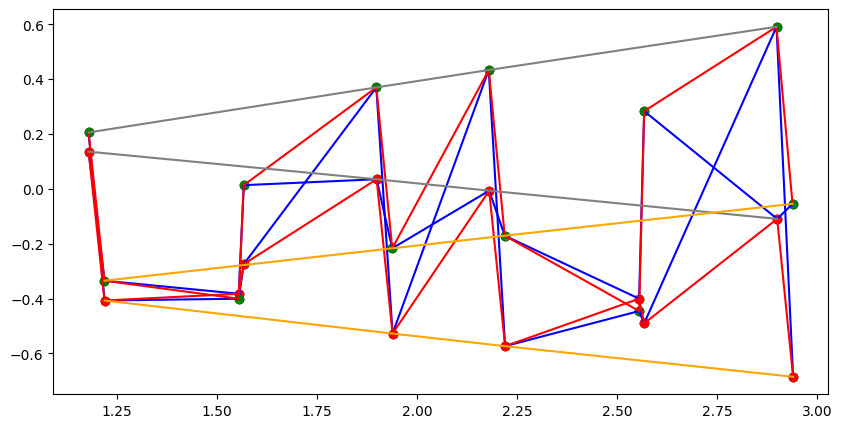

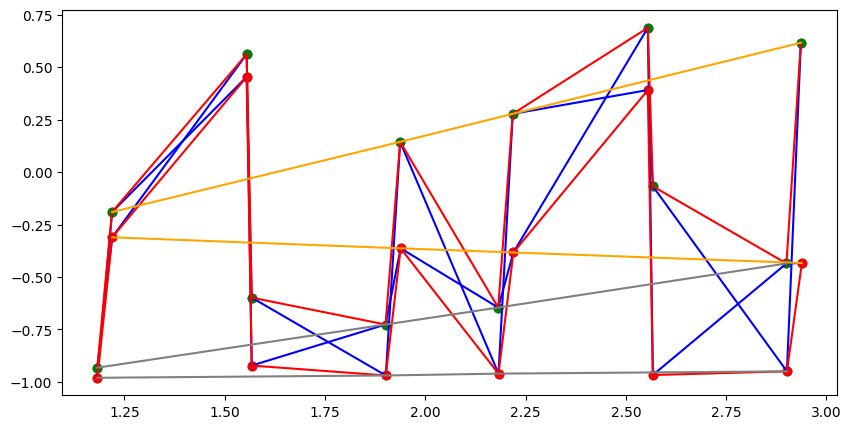

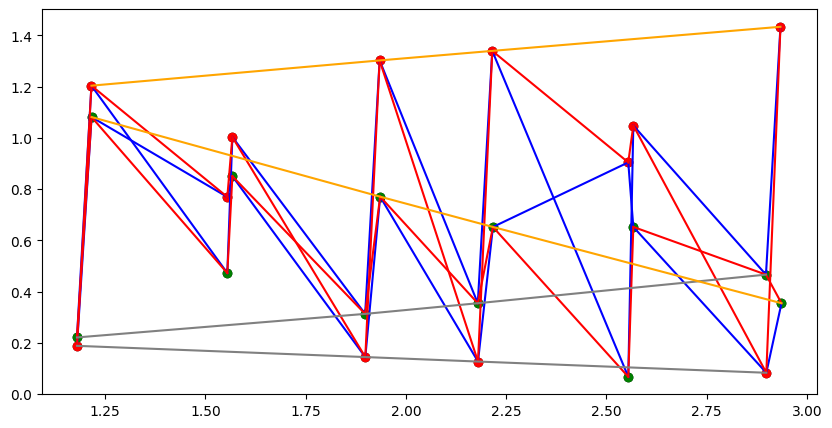

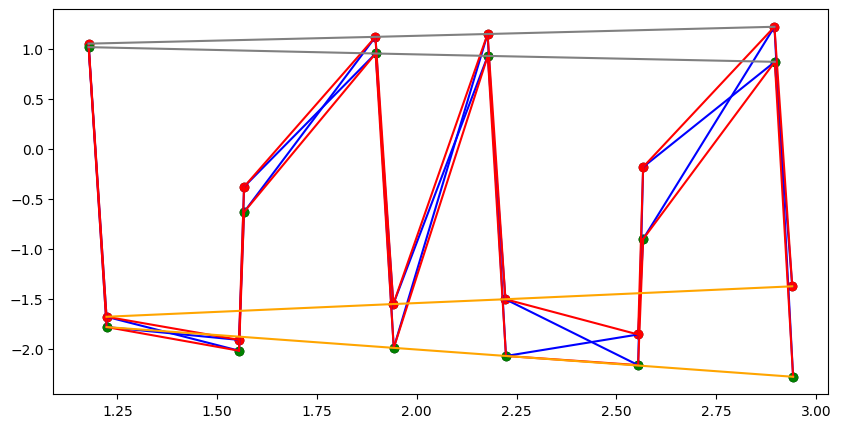

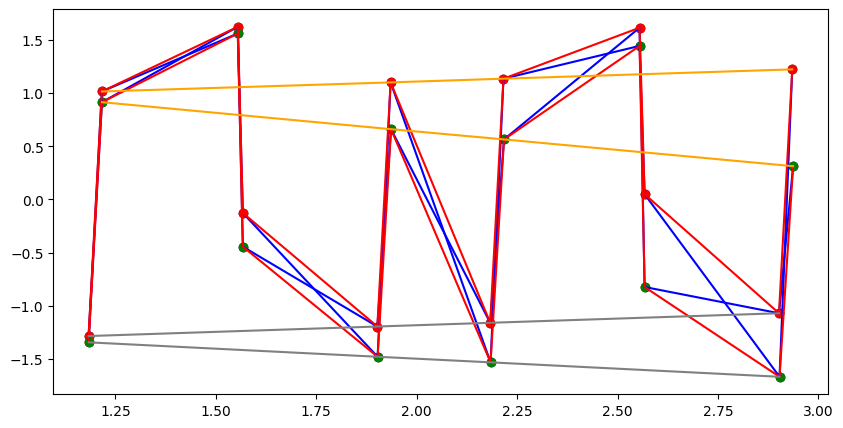

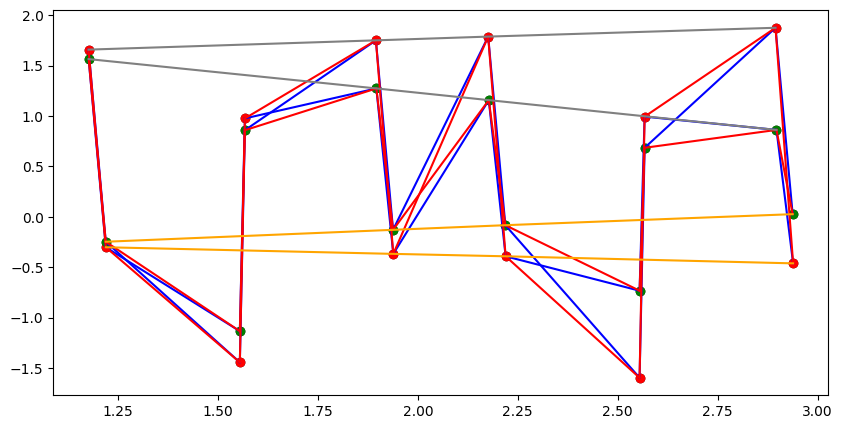

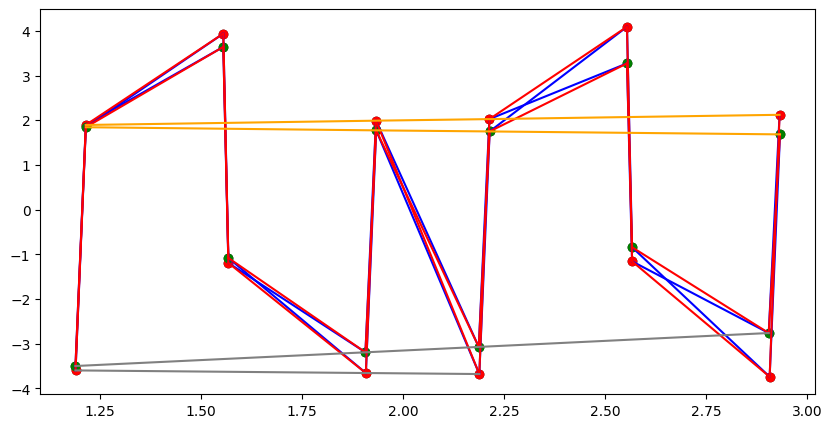

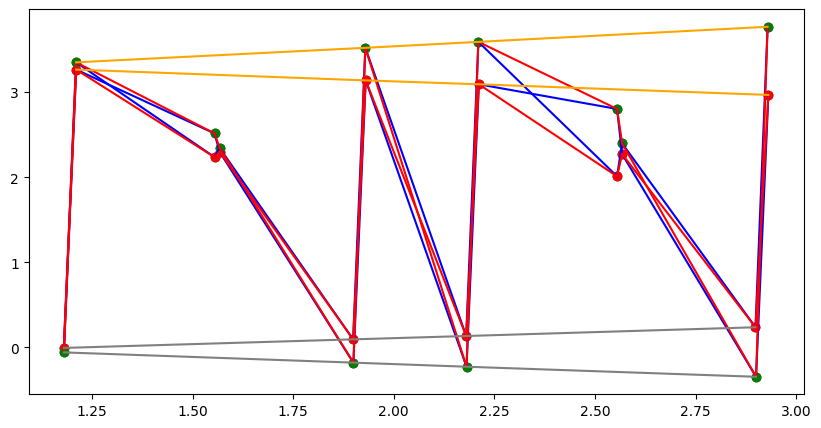

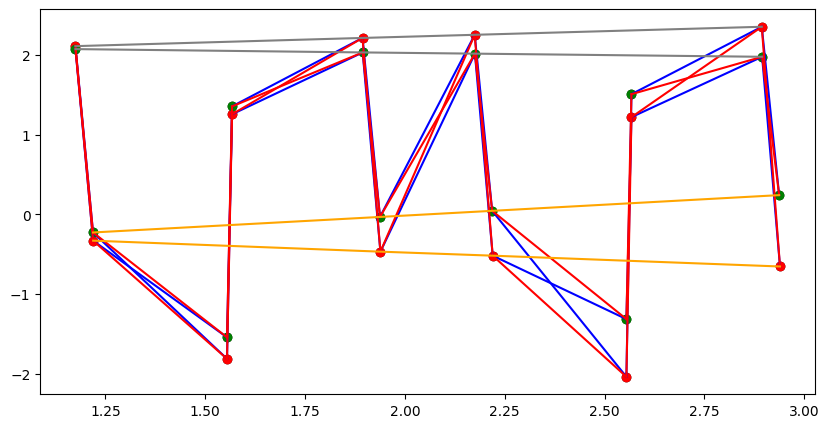

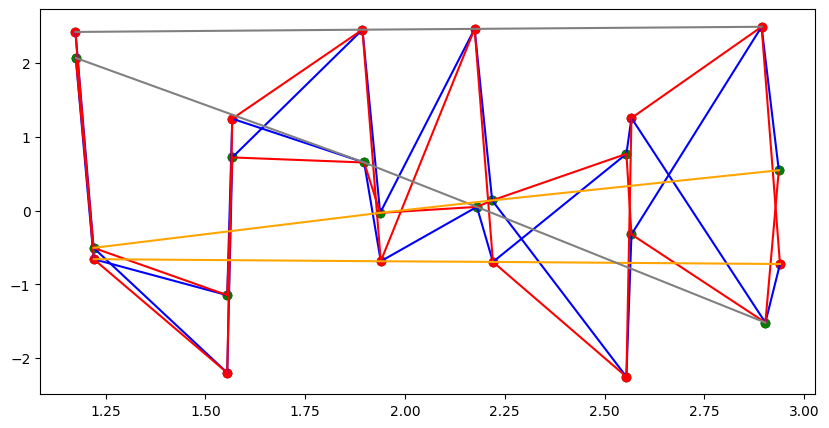

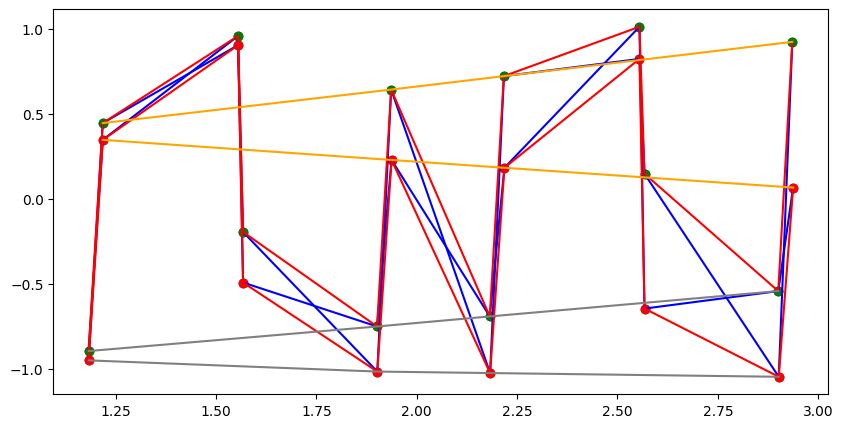

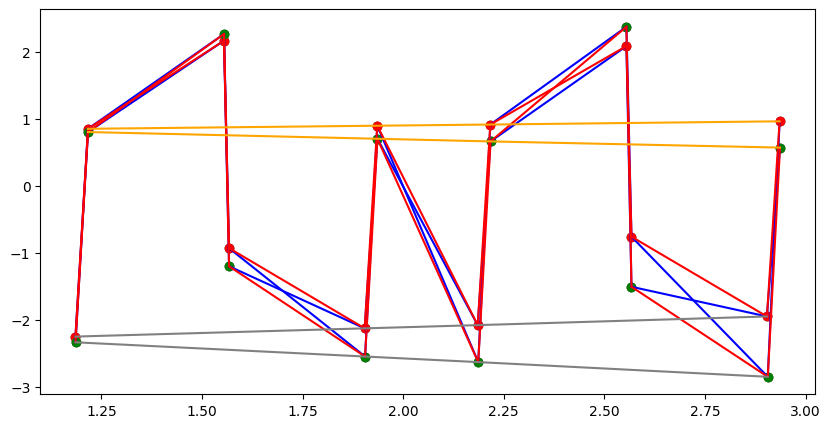

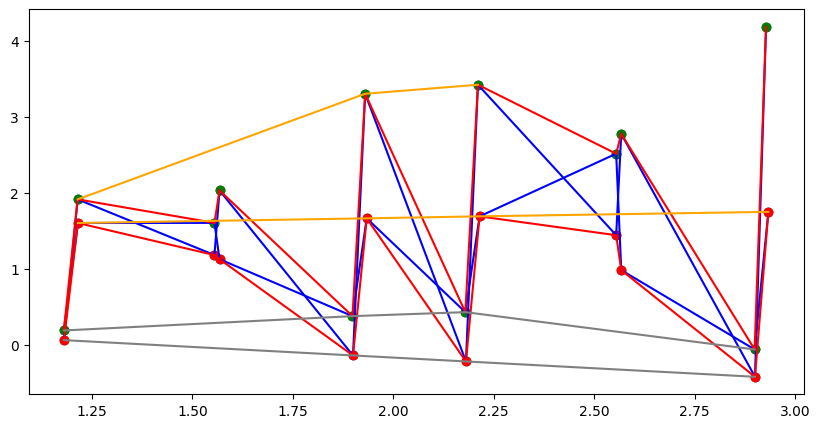

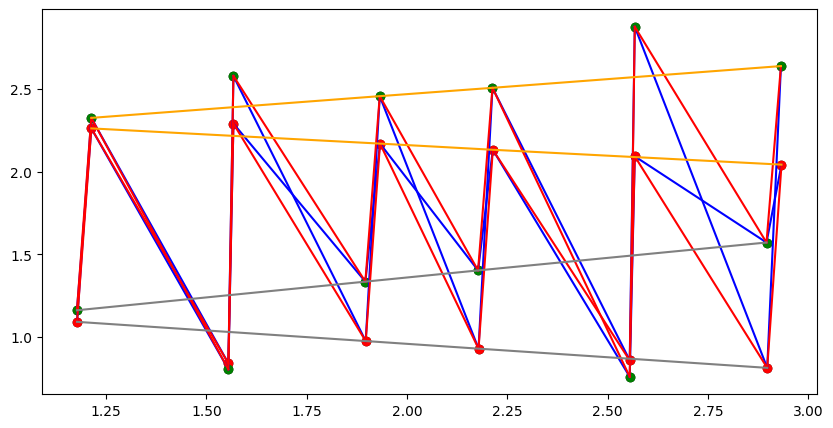

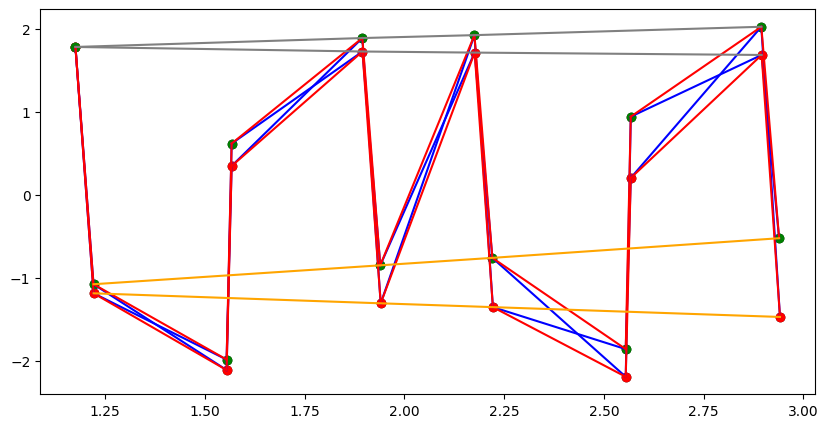

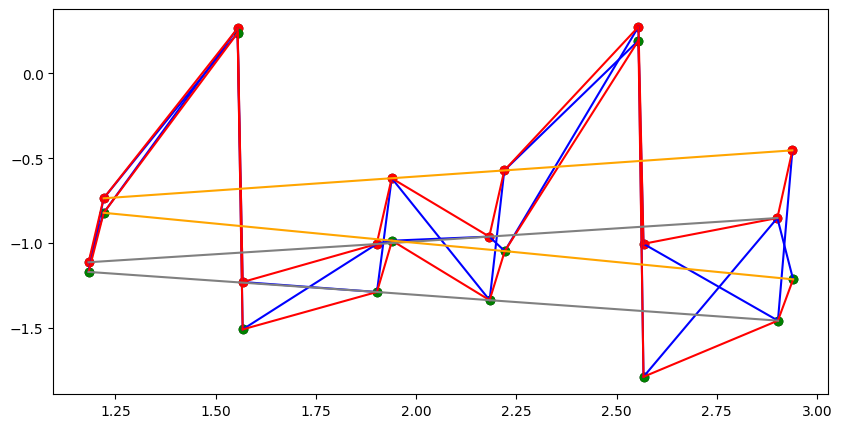

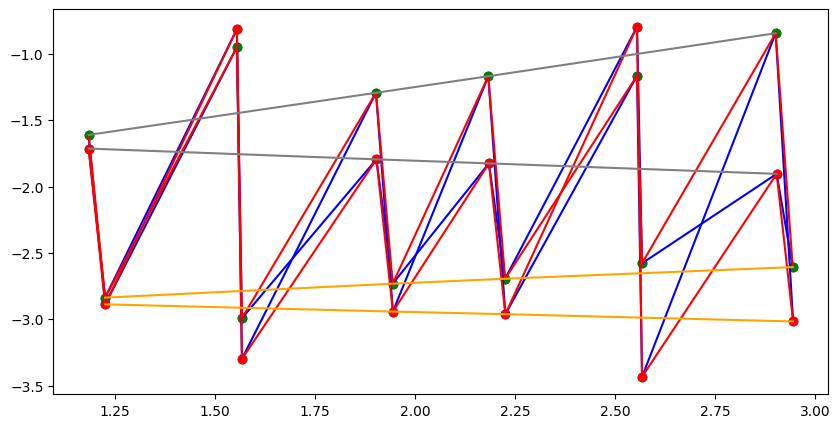

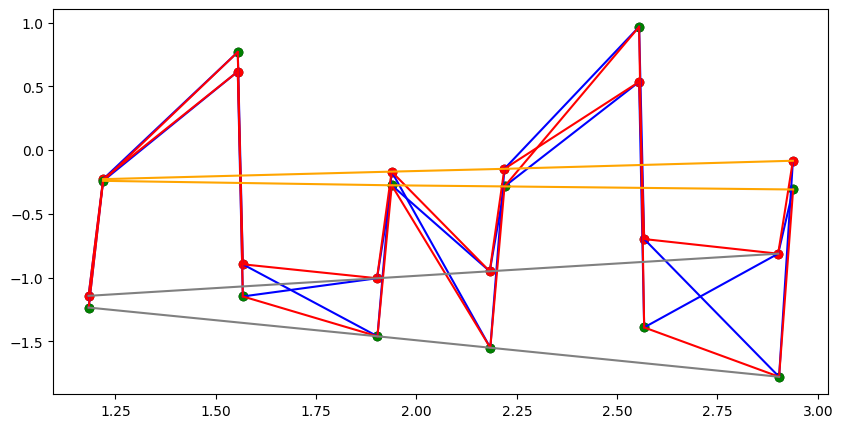

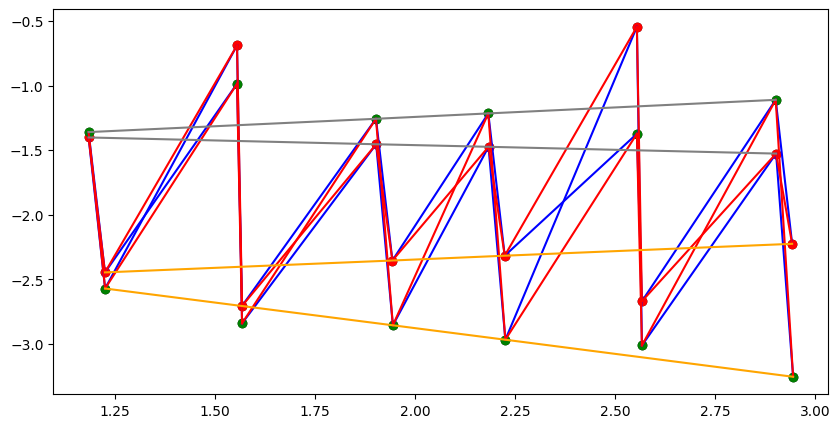

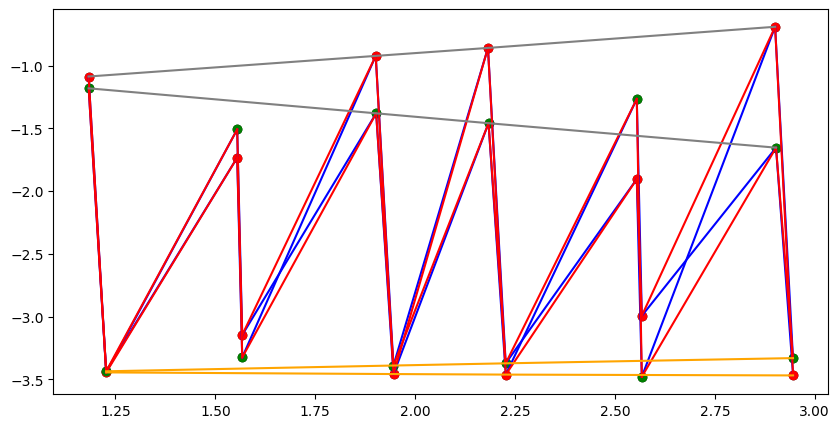

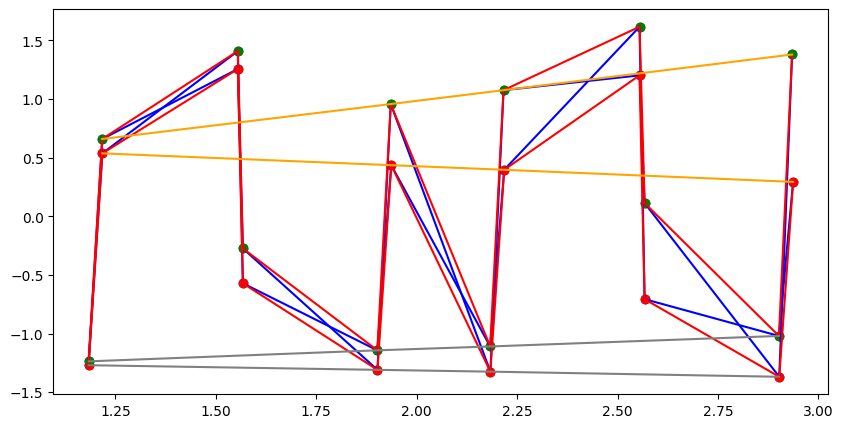

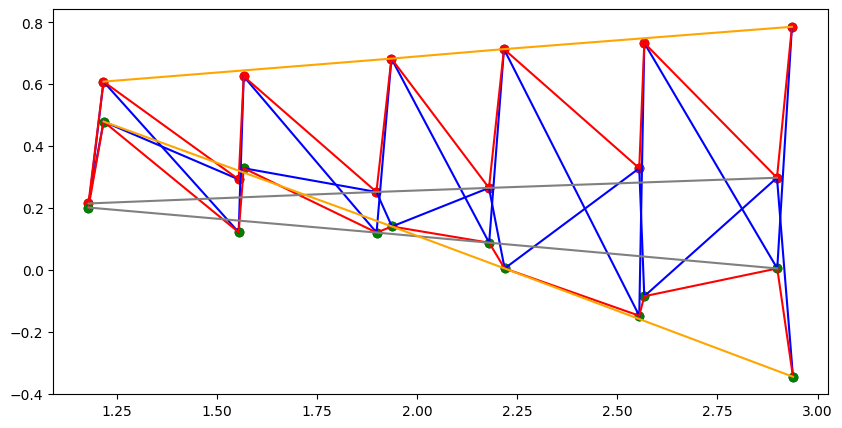

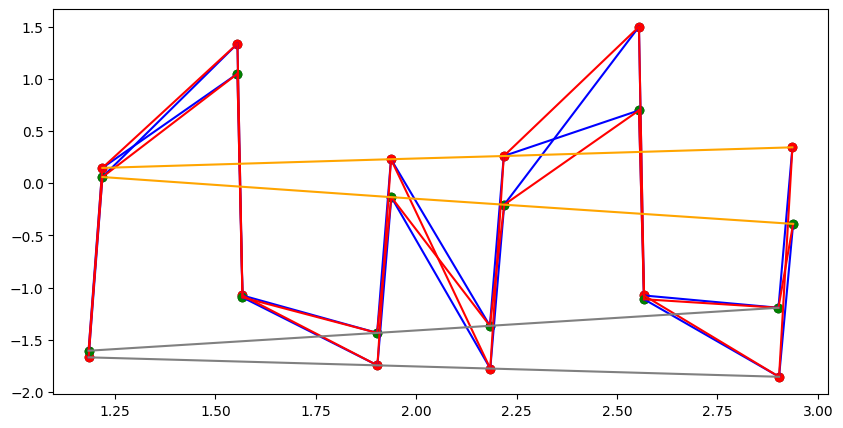

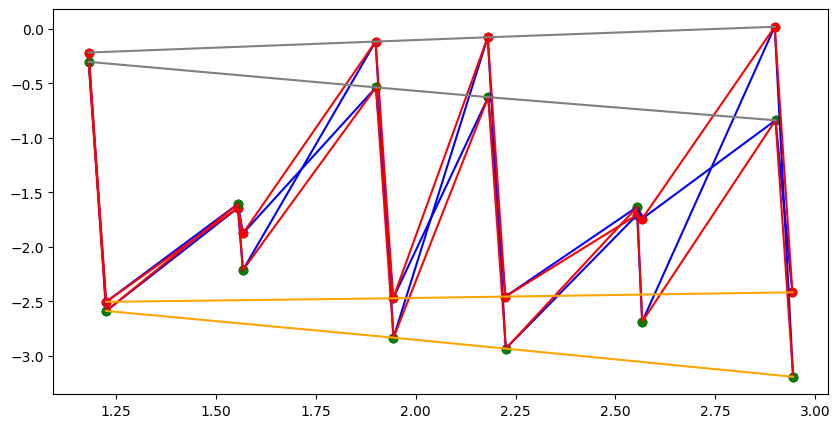

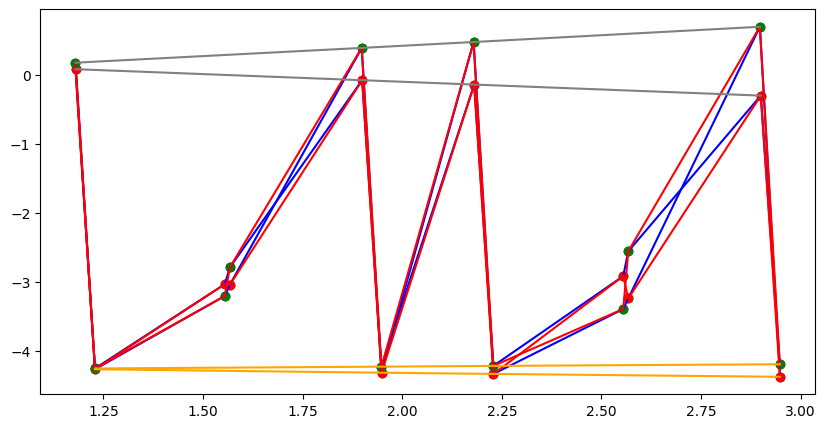

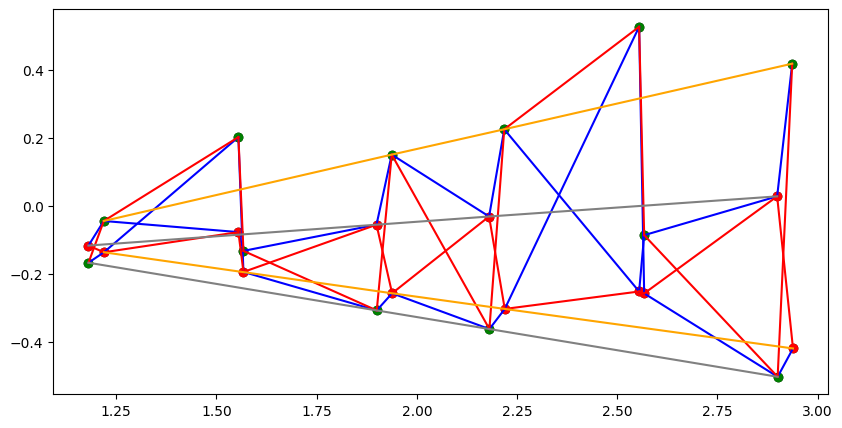

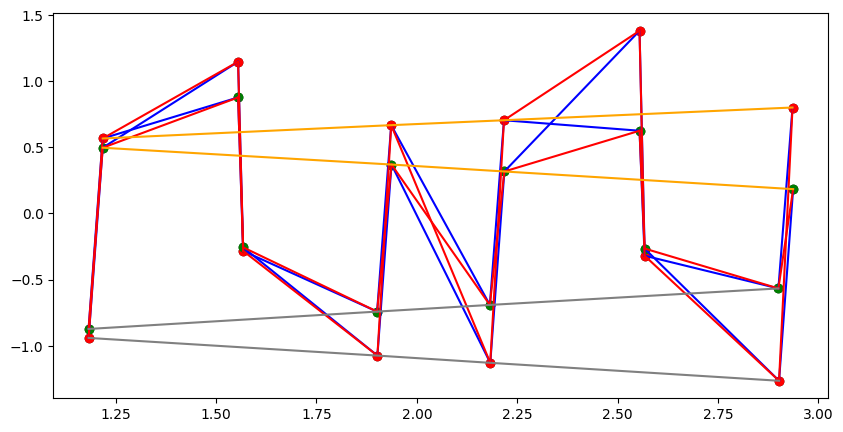

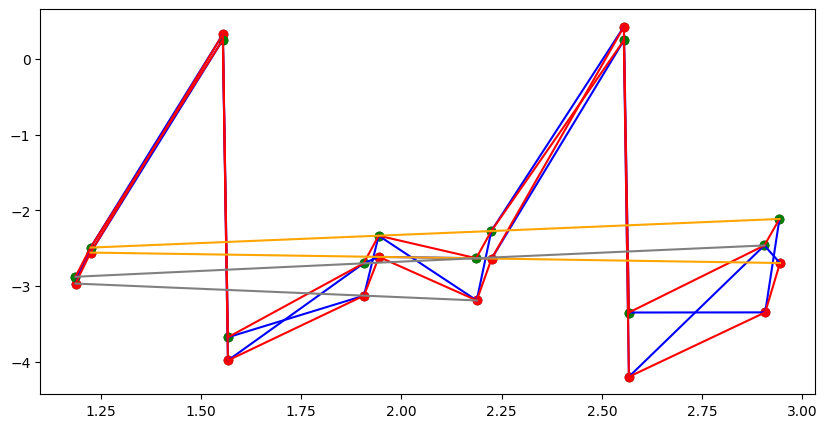

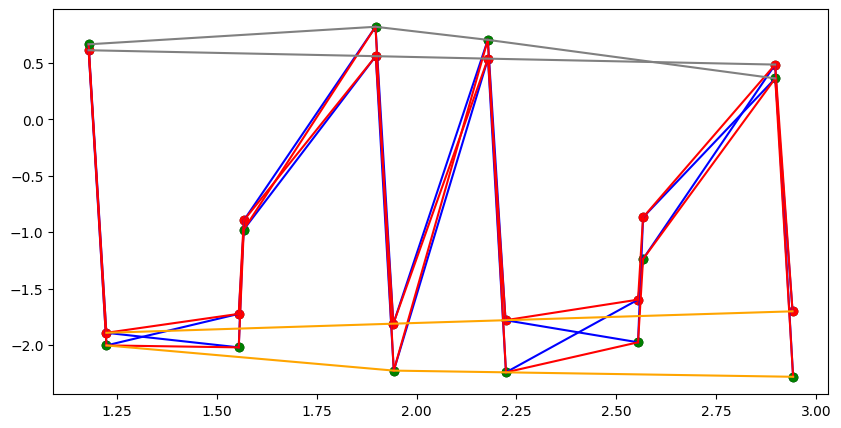

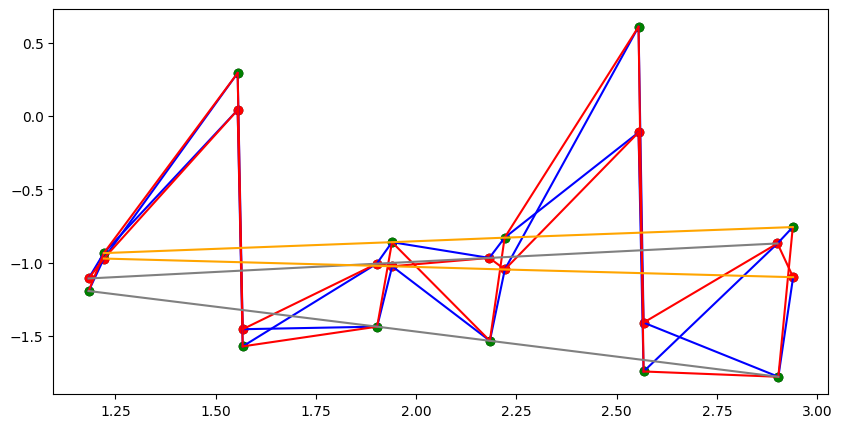

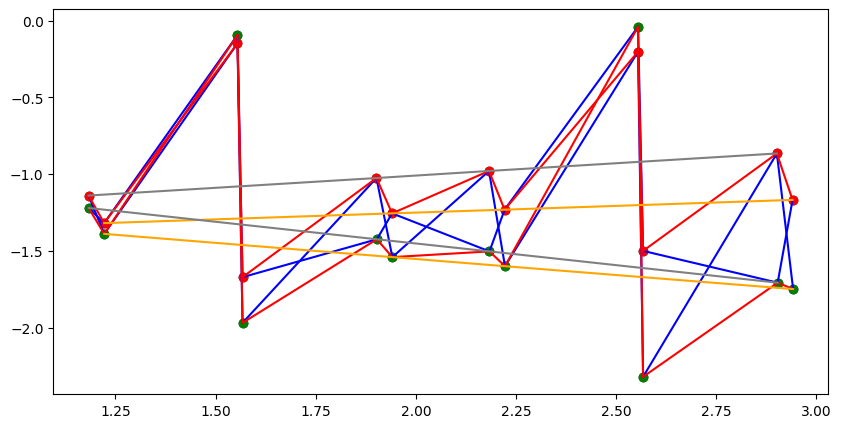

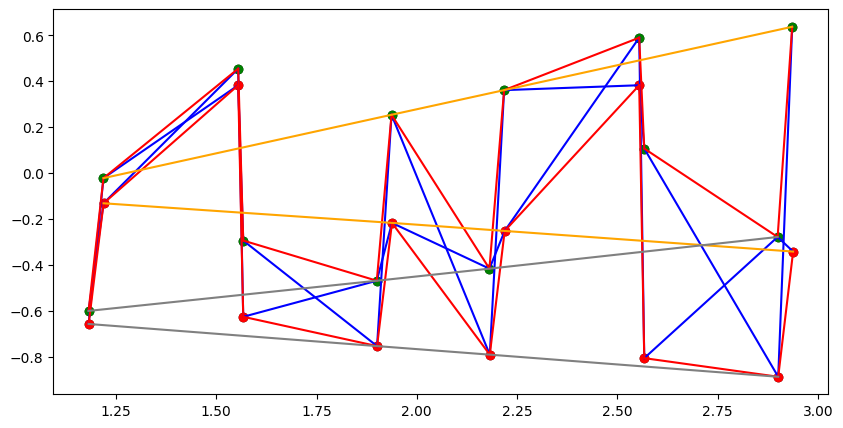

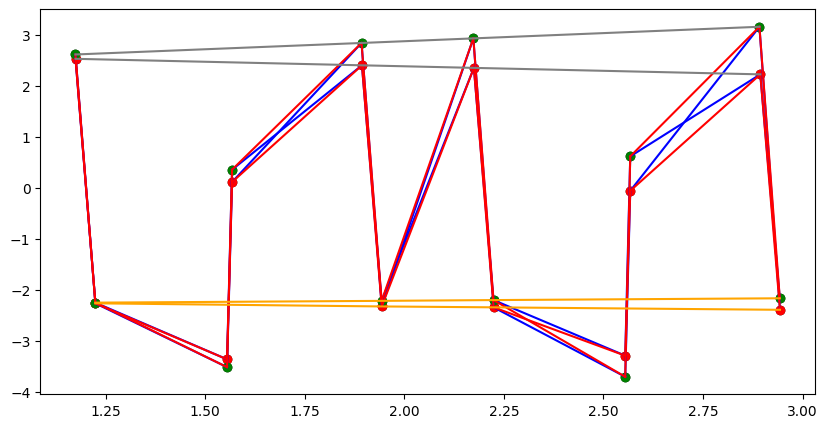

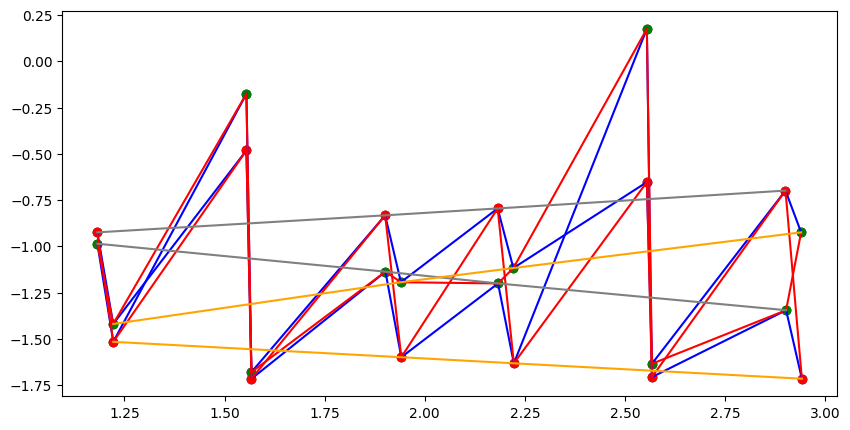

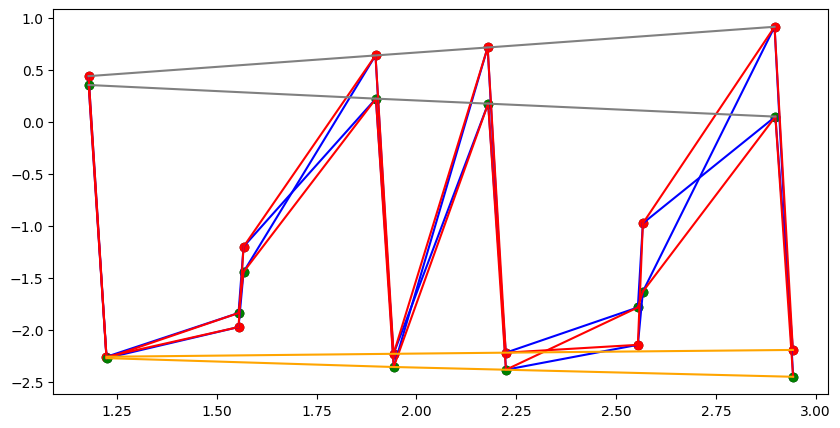

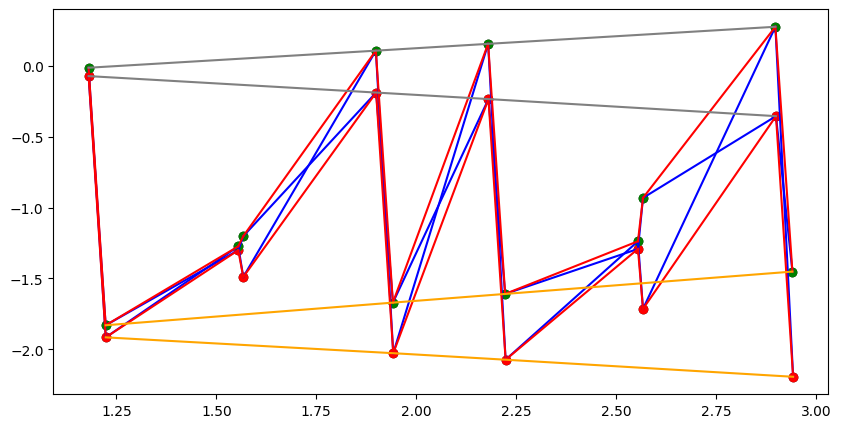

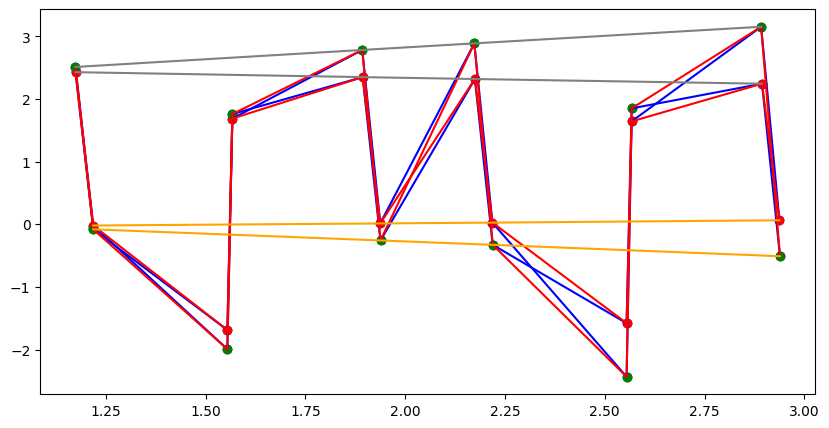

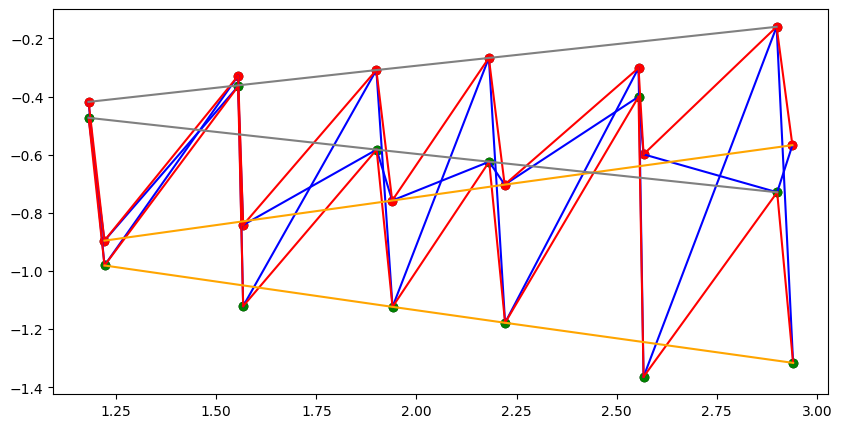

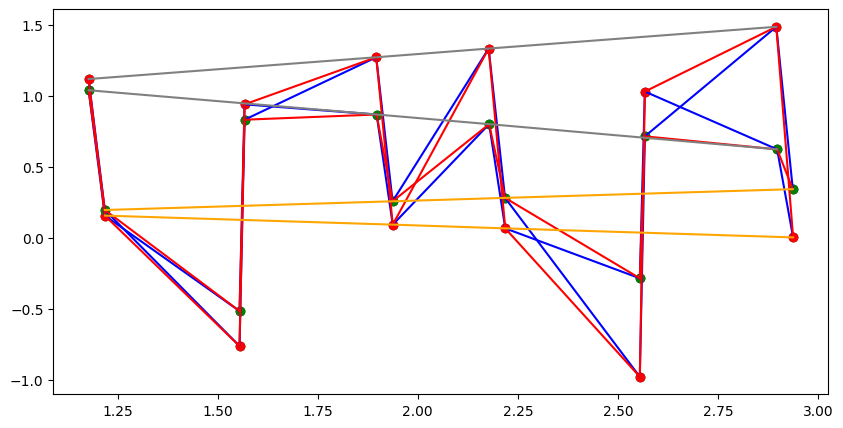

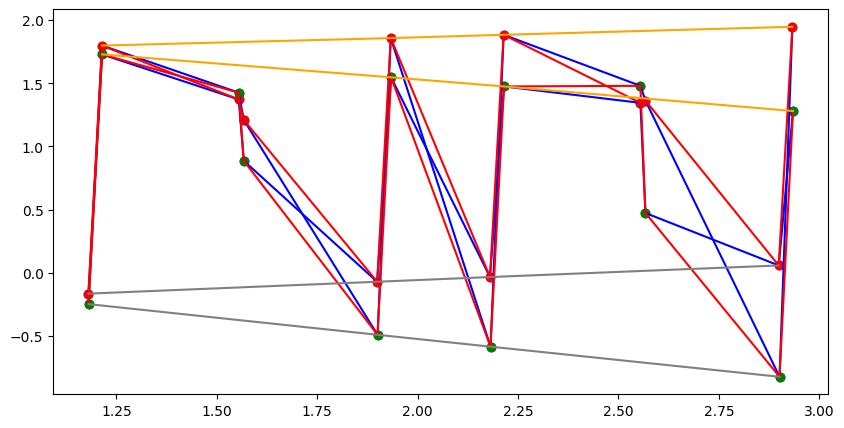

In [12]:
random.shuffle(data)
data_GNN, data_tracks = zip(*data)

# split data into training and test datasets
split_index = int(0.8 * len(data_GNN))
train_dataset = data_GNN[:split_index]
test_dataset = data_GNN[split_index:]
data_tracks = data_tracks[split_index:]

# train_dataset = train_dataset[:20000]
# test_dataset = train_dataset[:4000]

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())
print("Training dataset (events): ", len(train_dataset))
print("Test dataset (events): ", len(test_dataset))

# display few events
for k in range(40):
    plot_2D_graph(train_loader.dataset[k])

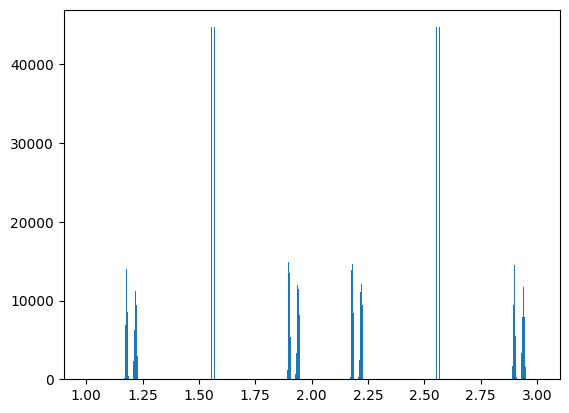

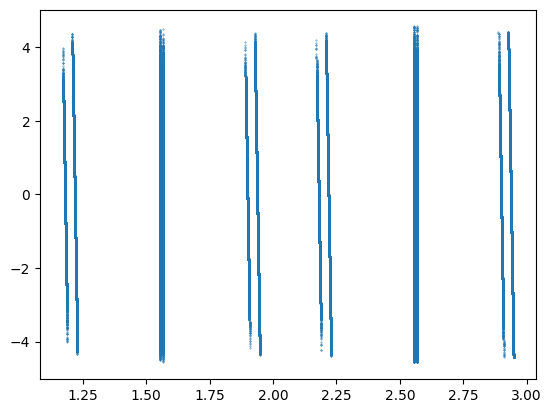

In [13]:
zz = np.empty([0])
xx = np.empty([0])
for k in range(len(test_loader.dataset)):
    zz = np.append(zz,train_loader.dataset[k].x[:,0].numpy())
    xx = np.append(xx,train_loader.dataset[k].x[:,1].numpy())

plt.hist(zz, bins=600, range=(1,3))  
plt.show()
#plt.hist(zz, bins=200, range=(1.54,1.58))  
#plt.show()
#plt.hist(zz, bins=200, range=(2.54,2.58))  
#plt.show()
plt.scatter(zz,xx,s=0.1)
plt.show()

In [14]:
weight = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 2, "hidden_node_dim": 128, "hidden_edge_dim": 256, "in_layers": 2, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 10, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=1e-5, amsgrad=True)

In [15]:
EPOCHS = 200

t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

start_time = time()
epoch_times = []

for epoch in range(EPOCHS):
    ep += 1
    
    epoch_start_time = time()
    
    model.train()
    acc, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    epoch_end_time = time()
    epoch_times.append(epoch_end_time - epoch_start_time)
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    remaining_time = avg_epoch_time * (EPOCHS - (epoch + 1))
    remaining_minutes, remaining_seconds = divmod(remaining_time, 60)
    
    clear_output(wait=True)
    print('Epoch: {}, Accuracy: {:.4f}, Time: {:.2f}s, Avg. Time/Epoch: {:.2f}s, Remaining Time: {:.0f}min:{:.0f}s'.format(
        ep, acc, epoch_end_time - epoch_start_time, avg_epoch_time, remaining_minutes, remaining_seconds))
    
end_time = time()
total_training_time = end_time - start_time
total_minutes, total_seconds = divmod(total_training_time, 60)
print('Total Training Time: {:.0f}min:{:.0f}s'.format(total_minutes, total_seconds))

Epoch: 200, Accuracy: 0.9954, Time: 21.83s, Avg. Time/Epoch: 21.71s, Remaining Time: 0min:0s
Total Training Time: 72min:22s


In [16]:
print("Test loss and accuracy: ",evaluate(model, test_loader))

Test loss and accuracy:  (0.9953538968300767, 10.001564224621688)


In [17]:
# save model
torch.save(model.state_dict(), './model_name.pth')

# load model
# model.load_state_dict(torch.load('./model_name.pth'))

(0.0, 1.05)

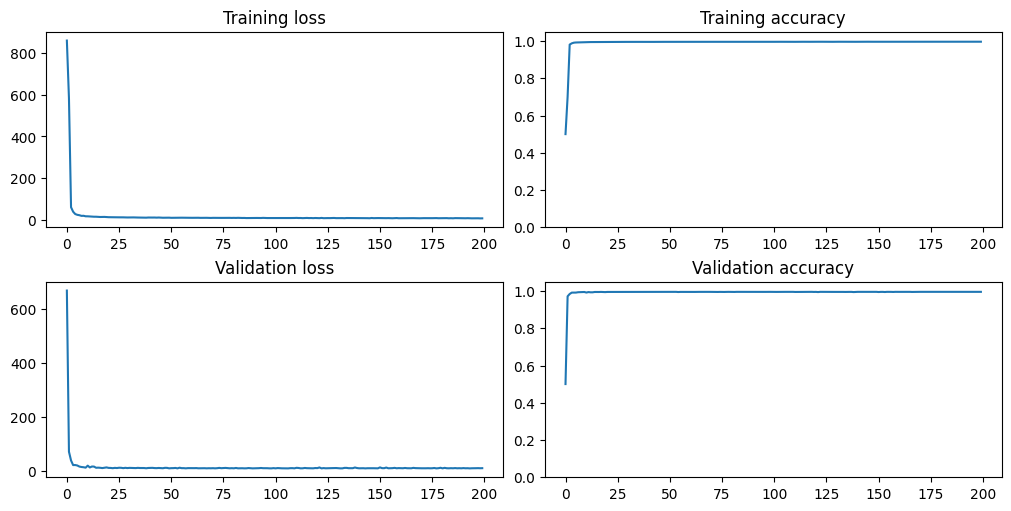

In [18]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10, 5))

axs[0][0].plot(np.arange(len(t_loss_v)), t_loss_v)
axs[0][0].set_title("Training loss")
axs[0][0].set_yscale("linear")

axs[0][1].plot(np.arange(len(t_acc_v)), t_acc_v)
axs[0][1].set_title("Training accuracy")
axs[0][1].set_yscale("linear")
axs[0][1].set_ylim(0, 1.05)

axs[1][0].plot(np.arange(len(v_loss_v)), v_loss_v)
axs[1][0].set_title("Validation loss")
axs[1][0].set_yscale("linear")

axs[1][1].plot(np.arange(len(v_acc_v)), v_acc_v)
axs[1][1].set_title("Validation accuracy")
axs[1][1].set_yscale("linear")
axs[1][1].set_ylim(0, 1.05)

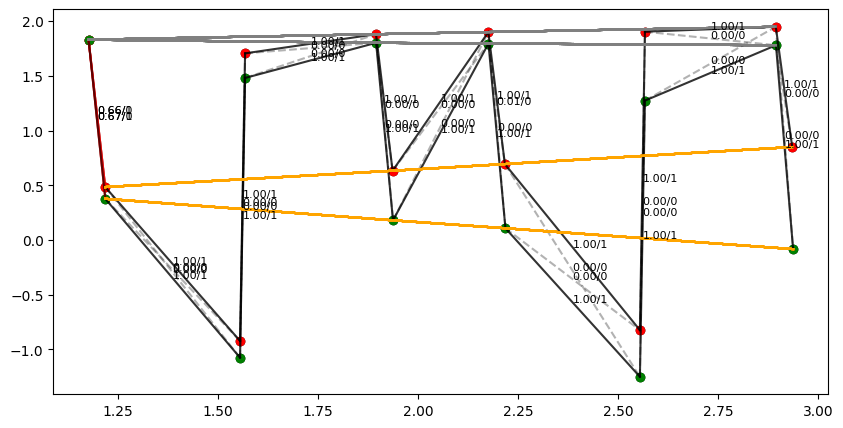

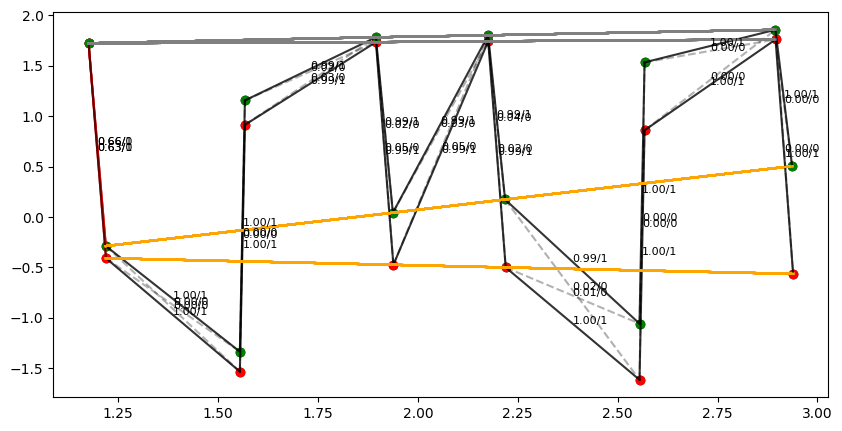

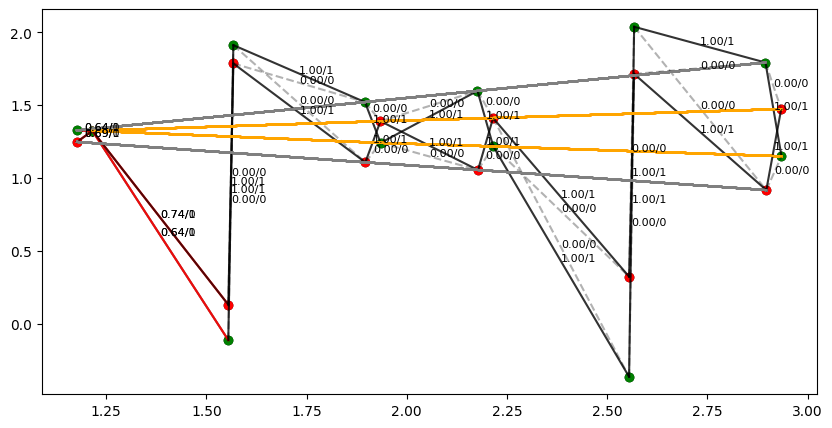

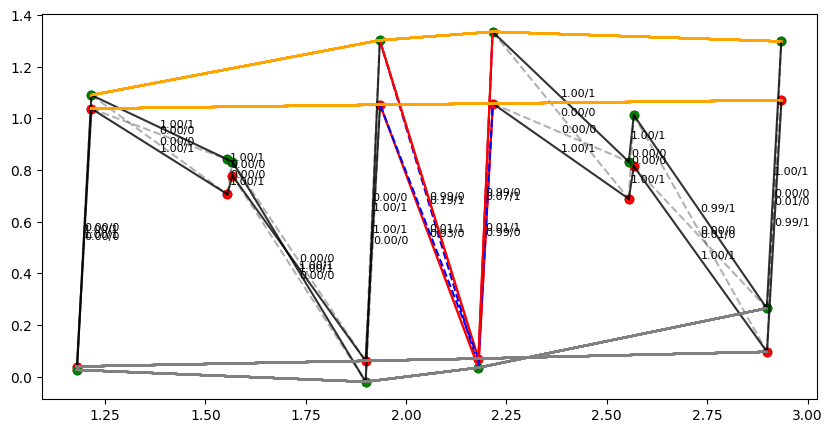

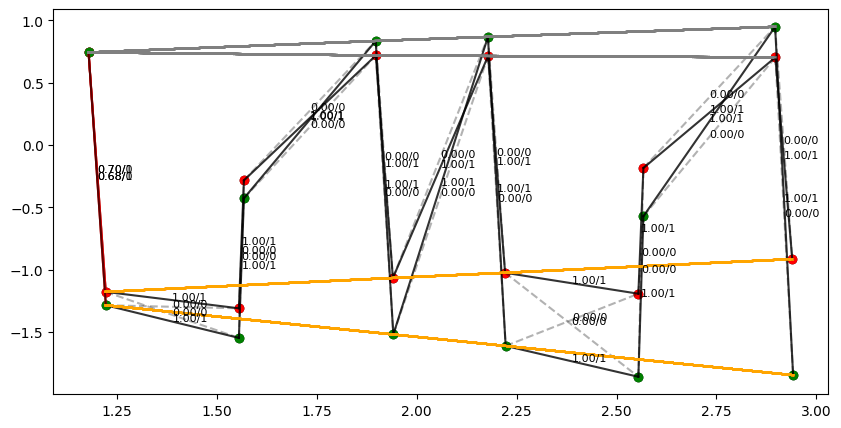

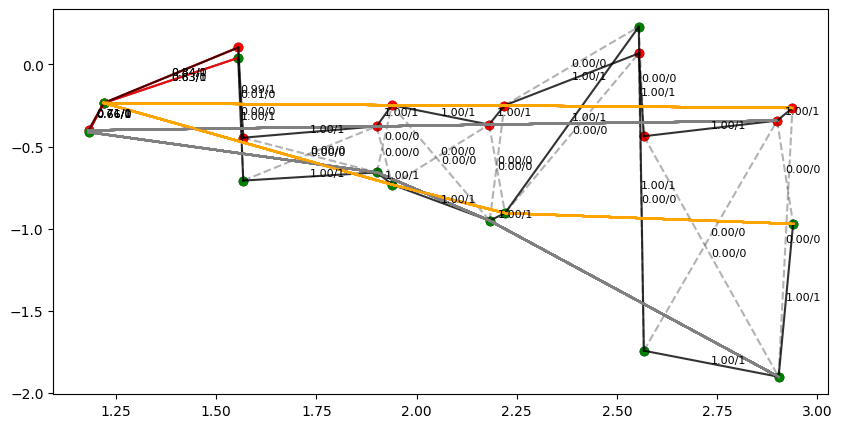

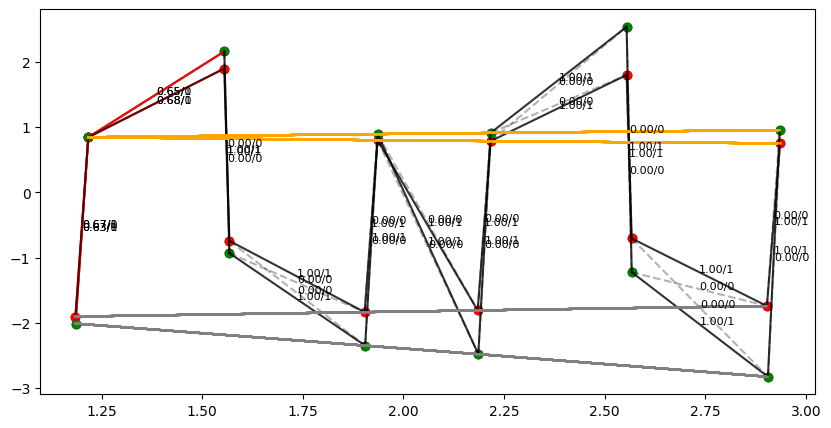

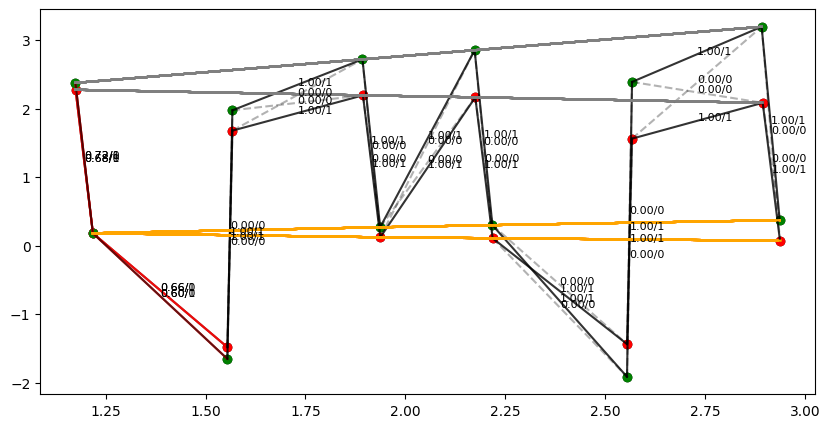

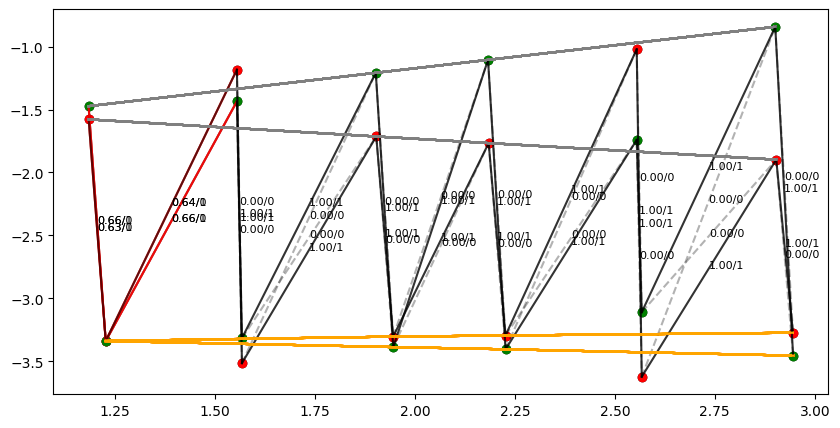

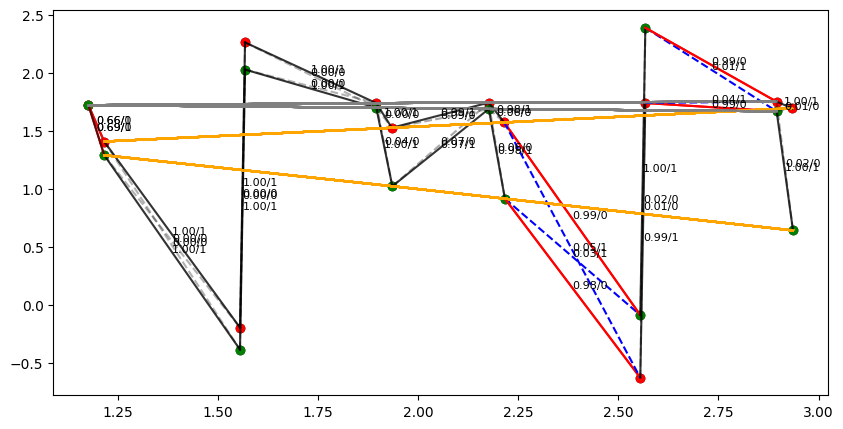

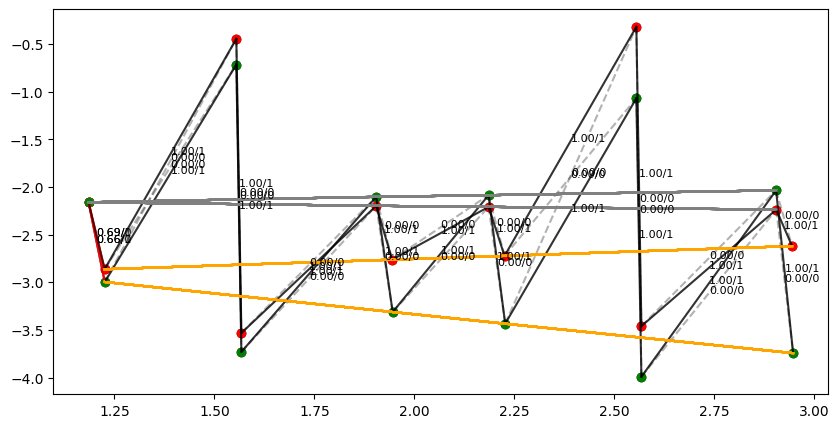

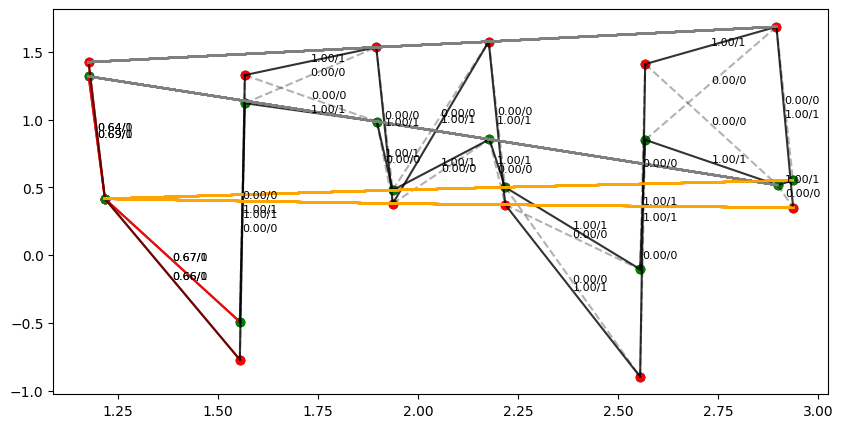

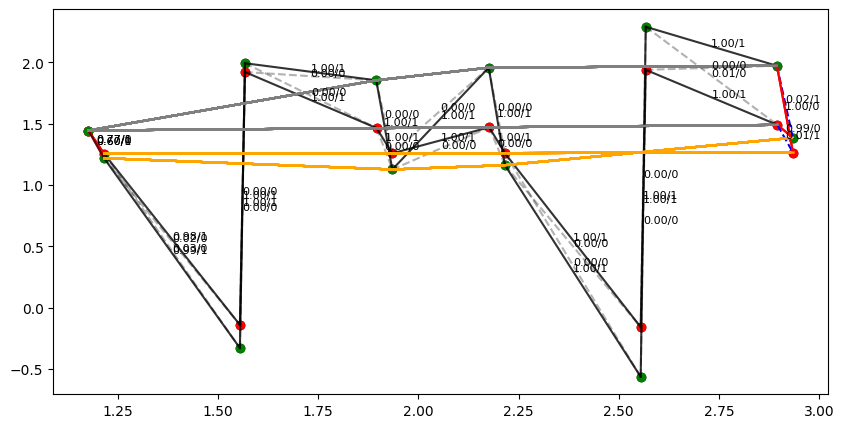

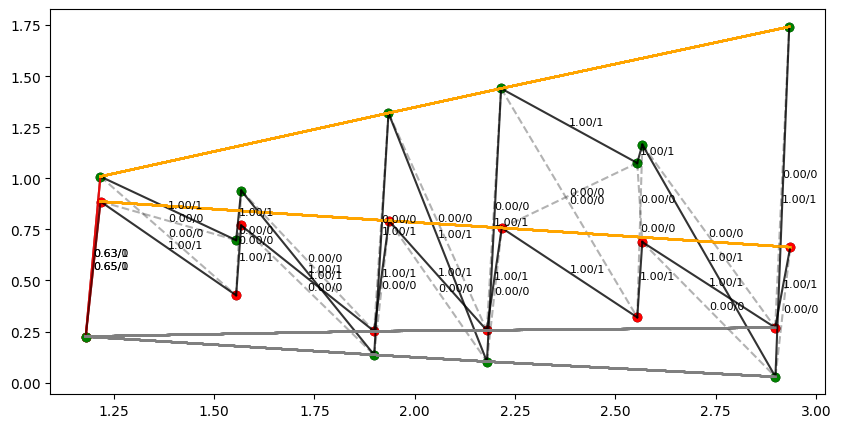

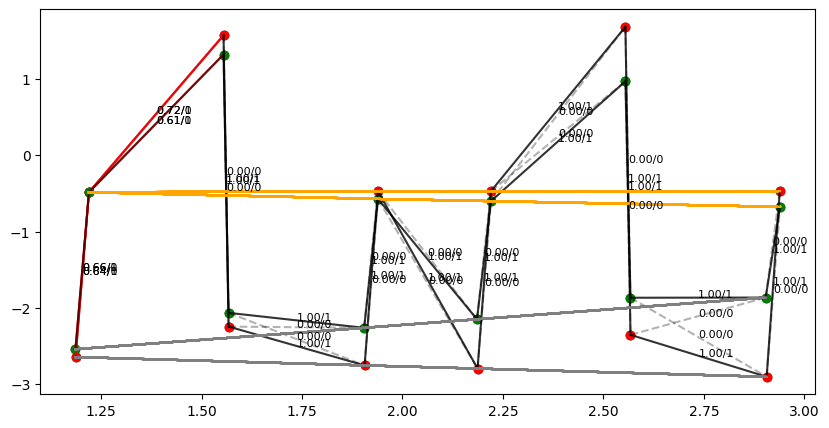

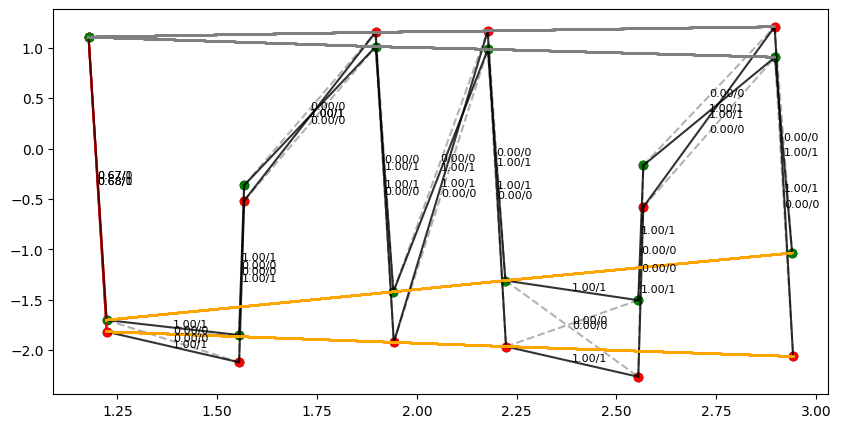

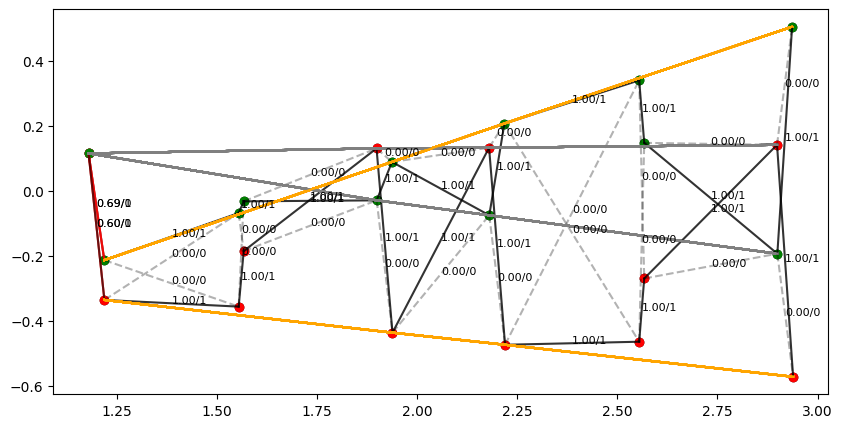

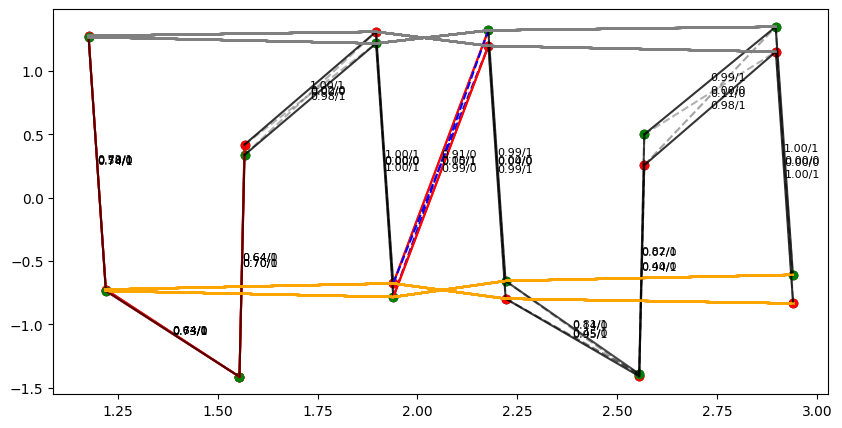

In [19]:
def plot_2D_classified(event, preds, cut=0.5, error_only=False):

#     print(event)
#     print(event.x)
#     print(event.pid)
#     print(event.y)
#     print(preds)
        
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    preds = preds.detach().numpy()
    
    # Check, whether there are any misidentified edges
    error = False
    for j in range(len(labels)):
        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            error = True
        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            error = True        
    # plot only if identification error appears
    if error or (not error_only):
        plt.figure(figsize=(10,5))

        plt.scatter(x, y, c='k')

        idx0 = np.where(event.pid[:].numpy() == 0)[0]
        idx1 = np.where(event.pid[:].numpy() == 1)[0]
        idx2 = np.where(event.pid[:].numpy() == 2)[0] 
        plt.scatter(x[idx0], y[idx0], c='magenta')
        plt.scatter(x[idx1], y[idx1], c='red')
        plt.scatter(x[idx2], y[idx2], c='green')

        for j in range(len(labels)):

            # False positives
            if preds[j] > cut and labels[j].item() < cut:
                plt.plot([x[edges[0,j]], x[edges[1,j]]],
                         [y[edges[0,j]], y[edges[1,j]]],
                         '-', c='red', alpha=preds[j])

            s = str('%01.2f' % preds[j]) + '/' + str(labels[j].item())
            plt.text((x[edges[0, j]] + x[edges[1, j]]) / 2.,
                     (y[edges[0, j]] + y[edges[1, j]]) / 2.,
                     s, fontsize=8)

            # False negatives
            if preds[j] < cut and labels[j].item() > cut:
                plt.plot([x[edges[0,j]], x[edges[1,j]]],
                         [y[edges[0,j]], y[edges[1,j]]],
                         '--', c='blue')

            # False positives
            if preds[j] > cut and labels[j].item() < cut:
                plt.plot([x[edges[0,j]], x[edges[1,j]]],
                         [y[edges[0,j]], y[edges[1,j]]],
                         '-', c='red', alpha=preds[j])

            # True positives
            if preds[j] > cut and labels[j].item() > cut:
                plt.plot([x[edges[0,j]], x[edges[1,j]]],
                         [y[edges[0,j]], y[edges[1,j]]],
                         '-', c='k', alpha=0.3 + 0.5*preds[j])

            # True negatives
            if preds[j] < cut and labels[j].item() < cut:
                plt.plot([x[edges[0,j]], x[edges[1,j]]],
                         [y[edges[0,j]], y[edges[1,j]]],
                         '--', c='k', alpha=0.3 + 0.5*preds[j])
                
    
            # plot true tracks    
            def track_plot(IDX,XYS,color):
                lx, ly = [], []
                for idx in IDX:
                    for layer, Z in enumerate(XYS):                
                        if math.isclose(x[idx]*z_scale, Z, abs_tol = 1.2):
                            lx.append(x[idx])
                            ly.append(y[idx])
                plt.plot(lx,ly,c=color)  

            track_plot(idx0,xs,"gray")
            track_plot(idx0,ys,"orange")
            track_plot(idx1,xs,"gray")
            track_plot(idx1,ys,"orange")
            track_plot(idx2,xs,"gray")
            track_plot(idx2,ys,"orange")

# display few events            
for k in range(400):
    data = test_loader.dataset[k].to(device)
    preds = torch.sigmoid(model(data)).to('cpu')
    plot_2D_classified(data.to('cpu'), preds, cut = 0.5, error_only = True)

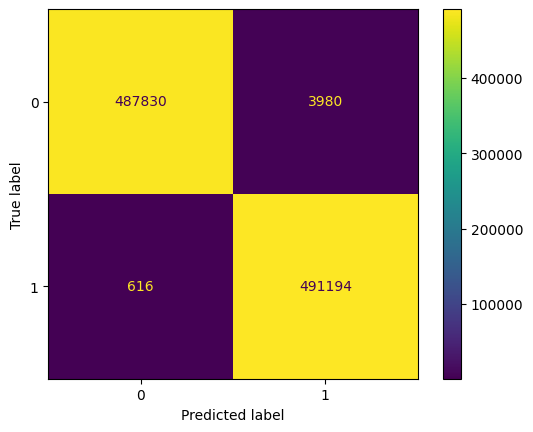

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

y_test = torch.cat([data.y.cpu() for data in test_loader.dataset])
y_pred = torch.cat([torch.sigmoid(model(data.to(device))) > 0.5 for data in test_loader.dataset]).cpu()

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()